### Phase 1: Supervised Fine-tuning with Cross-Entropy Loss

- Objective: Train a ViT5-based Text-to-SQL model using standard cross-entropy (CE) loss on Vietnamese natural language questions and corresponding SQL queries.
- Input: Natural language question + table schema (as a string).
- Output: SQL query (as a sequence of tokens).

- Model: `VietAI/vit5-base`, extended with custom SQL-related tokens such as SELECT, WHERE, price, city, etc.
- Trainer: Hugging Face `Seq2SeqTrainer` with standard CE-based training.
- Tokenizer: Resized to include special tokens and keywords from the dataset.

- Dataset:
  - `train_text2sql.json` and `val_text2sql.json` for training and validation
  - `test_text2sql.json` reserved for final evaluation

- Training configuration:
  - Epochs: 12
  - Learning rate: 3e-4
  - Batch size: 8
  - Gradient accumulation: 1
  - Precision: fp16 enabled
  - Save strategy: every 500 steps
  - Evaluation strategy: every 100 steps
  - Early stopping and checkpoint cleaning enabled

- Logging and Output:
  - Training logs saved to `model/logs/training_log_phase1.csv`
  - Model checkpoints saved under `model/save_training`
  - Final trained model stored in `model/Phase1_CEonly`

- Purpose of Phase 1:
  - Teach the model basic SQL structure and token-level understanding.
  - Build a strong initialization point for further fine-tuning with reward-based hybrid loss in Phase 2.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Dự án - báo cáo/Do_an_HK3_DT2210L_Text_To_SQL/vi_t5_text2sql

/content/drive/MyDrive/Dự án - báo cáo/Do_an_HK3_DT2210L_Text_To_SQL/vi_t5_text2sql


In [ ]:
!pip install transformers datasets sentencepiece evaluate sacrebleu -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and

In [ ]:
# ======== IMPORT ========
import os
import json
import re
import torch
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
from transformers import EarlyStoppingCallback
from datasets import Dataset as HFDataset
from sklearn.model_selection import train_test_split
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer,
    Seq2SeqTrainingArguments, DataCollatorForSeq2Seq,
    EarlyStoppingCallback, GenerationConfig, TrainerCallback
)

In [ ]:
# =================== CONFIG =====================
model_name = "VietAI/vit5-base"
output_dir = "model/save_training"
save_dir = "model/Phase1_CEonly"
logs = "model/logs"
# ======  Load processed JSON (train/val/test) ======

with open("data/processing/phase1/train_text2sql.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open("data/processing/phase1/val_text2sql.json", "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ======  Convert to HuggingFace Datasets ======
train_dataset = HFDataset.from_list([
    {
        "input": f"Câu hỏi: {item['Question']} | Schema: {item['Schema']}",
        "output": item['SQL']
    } for item in train_data
])

val_dataset = HFDataset.from_list([
    {
        "input": f"Câu hỏi: {item['Question']} | Schema: {item['Schema']}",
        "output": item['SQL']
    } for item in val_data
])
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# ====== 3. Print one sample from each dataset ======
print("\n--- Một mẫu từ tập huấn luyện ---")
print(train_dataset[0])

print("\n--- Một mẫu từ tập kiểm định ---")
print(val_dataset[0])


Train samples: 8500
Validation samples: 1000

--- Một mẫu từ tập huấn luyện ---
{'input': 'Câu hỏi: Bạn có biết căn nào có tầng là 1 hoặc phòng tắm là 3 không? | Schema: floors[str], bathrooms[str], price[float]', 'output': 'SELECT * FROM price_house WHERE floors = 1 OR bathrooms = 3'}

--- Một mẫu từ tập kiểm định ---
{'input': 'Câu hỏi: Nhà nào ít đường vào nhất? | Schema: access_road[float], price[float]', 'output': 'SELECT * FROM price_house ORDER BY access_road ASC LIMIT 1'}


In [ ]:
# ==================== MODEL + TOKENIZER =====================
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Add special tokens for SQL
custom_tokens = [
    # SQL keywords
    "SELECT", "FROM", "WHERE", "GROUP BY", "ORDER BY", "COUNT", "AVG", "MIN", "MAX",
    "AND", "OR", "DESC", "ASC", "SQL", "Schema", "Question",

    # Operators
    "<", ">", "=", "<=", ">=", "!=", "LIKE", "IN", "*",

    # Table + Columns
    "price_house", "address", "area", "frontage", "access_road", "house_direction",
    "balcony_direction", "floors", "bedrooms", "bathrooms", "legal_status", "furniture_state",
    "price", "city", "district", "ward", "cluster_label",

    # User slang / shorthand
    "tr", "ty", "gia", "dien tich",

    # Column types
    "[str]", "[int]", "[float]", "[bool]", "[date]"
]
tokenizer.add_tokens(custom_tokens)
model.resize_token_embeddings(len(tokenizer))

# Set up output generation configuration
model.generation_config = GenerationConfig(
    max_length=64,
    num_beams=4,
    early_stopping=True,
    do_sample=False
)

# ================ TOKENIZATION =====================
def tokenize_fn(example):
    """
    Function to tokenize a data sample: convert input and output into token IDs.
    """
    model_inputs = tokenizer(
        example["input"], padding="max_length", truncation=True, max_length=512
    )
    labels = tokenizer(
        example["output"], padding="max_length", truncation=True, max_length=128
    )
    model_inputs["labels"] = [
            l if l != tokenizer.pad_token_id else -100 for l in labels["input_ids"]
        ]
    return model_inputs

tokenized_train = train_dataset.map(tokenize_fn)
tokenized_val = val_dataset.map(tokenize_fn)

Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Số lượng mẫu: 8500
Max length: 58 tokens
Mean length: 21.20 tokens
95th percentile: 42.0 tokens
99th percentile: 49.0 tokens


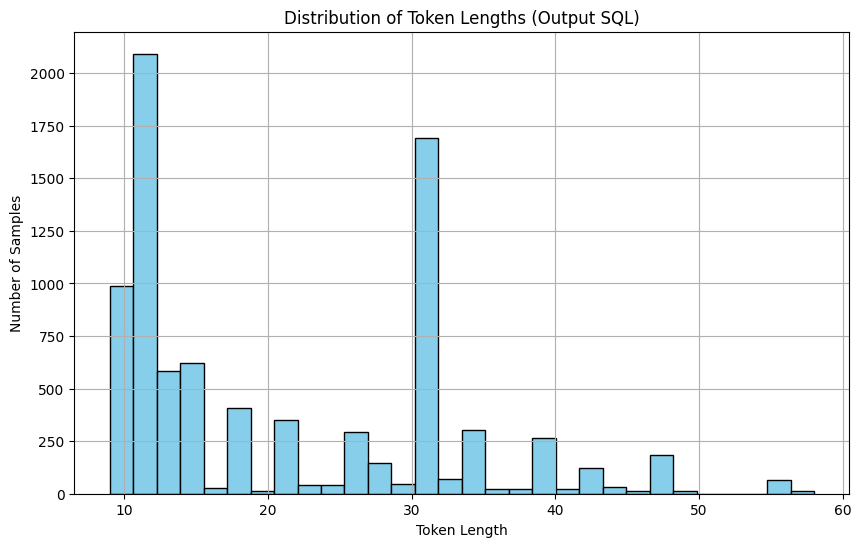

In [ ]:
# ==================== Analyze output length =====================

# 1. Collect all output sentences (the target texts).
outputs = [ex["output"] for ex in train_dataset]

# 2. Tokenize them without padding or truncation (padding=False, truncation=False).
tokenized_outputs = tokenizer(outputs, padding=False, truncation=False)

# 3. Calculate the length (number of tokens) for each tokenized output.
token_lengths = [len(ids) for ids in tokenized_outputs["input_ids"]]

print(f"Số lượng mẫu: {len(token_lengths)}")
print(f"Max length: {np.max(token_lengths)} tokens")
print(f"Mean length: {np.mean(token_lengths):.2f} tokens")
print(f"95th percentile: {np.percentile(token_lengths, 95)} tokens")
print(f"99th percentile: {np.percentile(token_lengths, 99)} tokens")

# 4. Plot a histogram if needed.
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, edgecolor="black", color="skyblue")
plt.xlabel('Token Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Token Lengths (Output SQL)')
plt.grid(True)
plt.show()

In [ ]:
class AggressiveCheckpointCleanerCallback(TrainerCallback):
    """
    Callback to aggressively delete older checkpoints to save disk space.
    Keeps only the latest checkpoint.
    """

    def on_save(self, args, state, control, **kwargs):
        output_dir = args.output_dir
        checkpoints = sorted(
            [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")],
            key=lambda x: int(x.split("-")[-1])
        )
        for ckpt in checkpoints[:-1]:
            shutil.rmtree(os.path.join(output_dir, ckpt), ignore_errors=True)

    def on_train_end(self, args, state, control, **kwargs):
        output_dir = args.output_dir
        for ckpt in os.listdir(output_dir):
            if ckpt.startswith("checkpoint-"):
                shutil.rmtree(os.path.join(output_dir, ckpt), ignore_errors=True)


In [ ]:
# ======== SETUP TRAINING ========
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-4,
    num_train_epochs=12,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3),
               AggressiveCheckpointCleanerCallback()]
)

# ======== START TRAINING ========
trainer.train()

# ======== SAVE MODEL AFTER TRAINING ========
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


<ipython-input-18-65a2628500c6>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss
100,4.827800,4.247176
200,3.937400,3.190934
300,2.315000,1.237532
400,1.235700,1.094608
500,1.024100,0.842461
600,0.809200,0.629647
700,0.668400,0.481935
800,0.510600,0.370135
900,0.433200,0.343780
1000,0.433600,0.352872


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('model/43-P1-CE/tokenizer_config.json',
 'model/43-P1-CE/special_tokens_map.json',
 'model/43-P1-CE/spiece.model',
 'model/43-P1-CE/added_tokens.json')

Saved training log to model/logs/training_log_43phase1.csv


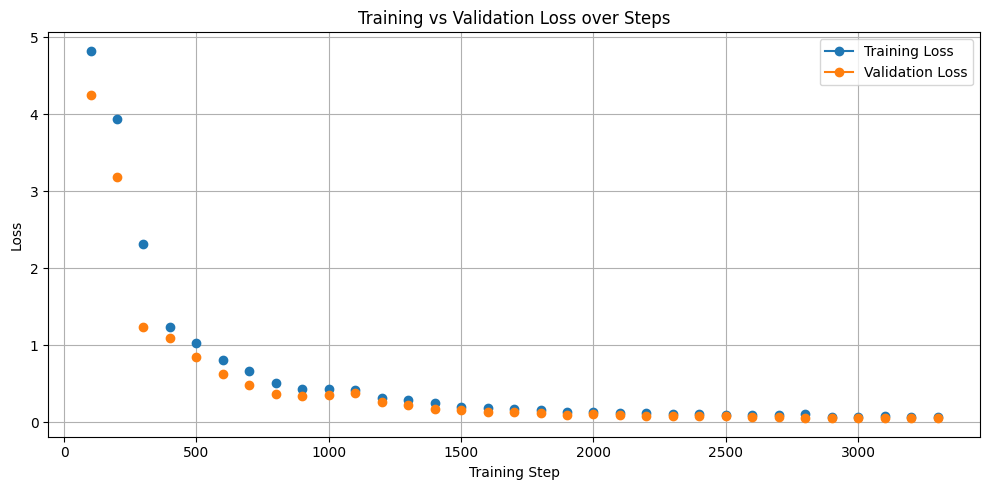

In [ ]:
# ======== Plot training and evaluation loss over steps ========
log_path = os.path.join(logs, "training_log_phase1.csv")
log_data = trainer.state.log_history

df_log = pd.DataFrame(log_data)
df_log.to_csv(log_path, index=False)
print(f"Saved training log to {log_path}")

steps = []
train_loss = []
val_loss = []

for entry in log_data:
    step = entry.get("step")
    if step is not None:
        steps.append(step)
        train_loss.append(entry.get("loss", None))
        val_loss.append(entry.get("eval_loss", None))

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Training Loss", marker="o")
plt.plot(steps, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss over Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# -*- coding: utf-8 -*-
"""
Evaluate a fine-tuned Text-to-SQL model by generating SQL queries
for each sample in the test set and comparing them with the ground truth queries.

Model: ViT5 (fine-tuned)
Dataset: test_text2sql.json
"""

import json
import re
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# ======== CONFIGURE PATHS ========
model_dir = "model/Phase1_CEonly"
test_path = "data/processing/phase1/test_text2sql.json"

# ======== LOAD MODEL AND TOKENIZER ========
tokenizer = T5Tokenizer.from_pretrained(model_dir)
model = T5ForConditionalGeneration.from_pretrained(model_dir)
model.eval().to("cuda")

# ======== CLEAN USER QUESTION ========
def clean_user_question(text: str) -> str:
    """
    Clean and normalize the input question, handling abbreviations and currency units.

    Args:
        text (str): Input user question.

    Returns:
        str: Cleaned question.
    """
    text = text.lower().strip()
    '''
    text = text.replace(",", ".")
    text = re.sub(r"(\d+(\.\d+)?)\s*(tỷ|ty|tỏi)", lambda m: str(int(float(m.group(1)) * 1e9)), text)
    text = re.sub(r"(\d+(\.\d+)?)\s*(triệu|tr)", lambda m: str(int(float(m.group(1)) * 1e6)), text)
    '''
    return text

# ======== GENERATE SQL QUERY ========
def generate_sql(question: str, schema: str, max_len: int = 128) -> str:
    """
    Generate an SQL query from a natural language question and table schema.

    Args:
        question (str): User question.
        schema (str): Table schema description.
        max_len (int): Maximum output length.

    Returns:
        str: Generated SQL query.
    """
    input_text = f"Question: {clean_user_question(question)} | Schema: {schema}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(model.device)
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_len,
        num_beams=4,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        decoder_start_token_id=tokenizer.pad_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# ======== EVALUATE TEST SET ========
def evaluate_test_set():
    """
    Run evaluation on the test set by generating SQL queries
    and comparing them with the ground truth queries.
    """
    with open(test_path, "r", encoding="utf-8") as f:
        test_data = json.load(f)

    print(f"Number of samples in test set: {len(test_data)}\n")

    for i, item in enumerate(test_data):
        question = item["Question"]
        schema = item["Schema"]
        gold_sql = item["SQL"]

        pred_sql = generate_sql(question, schema)

        print(f"========== Sample {i + 1} ==========")
        print(f"Question: {question}")
        print(f"Generated SQL:\n{pred_sql}")
        print(f"Ground Truth SQL:\n{gold_sql}\n")

# ======== MAIN PROGRAM ========
if __name__ == "__main__":
    evaluate_test_set()


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Number of samples in test set: 500

========== Sample 1 ==========
Question: Ở Hồ Chí Minh có căn nào tìm nhà giá dưới 9,8 tỷ không?
Generated SQL:
SELECT * FROM price_house WHERE price < 9800000000 AND city = 'Hồ Chí Minh' = city = 'Hồ Chí Minh' = = = 'Hồ Chí Minh' = = = 'Hồ Chí Minh' = = = 'Hồ Chí Minh' = = = 'Hồ Chí Minh' = = = 'Hồ Chí Minh' = = = 'Hồ Chí Minh'
Ground Truth SQL:
SELECT * FROM price_house WHERE price < 9800000000 AND city = 'Hồ Chí Minh'

========== Sample 2 ==========
Question: Nhà nào ít giá nhất?
Generated SQL:
SELECT * FROM price_house ORDER BY price ASC LIMIT 1 ASC 'Liên Yên' city = 'Hà Nội'
Ground Truth SQL:
SELECT * FROM price_house ORDER BY price ASC LIMIT 1

========== Sample 3 ==========
Question: Bất động sản nào có mặt tiền trên 8,1m?
Generated SQL:
SELECT * FROM price_house WHERE frontage > 8.1 frontage <= 'Bình Trưng' city = 'Hồ Chí Minh'
Ground Truth SQL:
SELECT * FROM price_house WHERE frontage > 8.1

========== Sample 4 ==========
Question: Có nhà nà